## This is a tutorial on how to build a Cache for GPT-4, chatGPT, Claude, Palm, Llama2

In this notebook we:
- use chromaDB to define add_cache(), get_cache(). We cache responses from the LLM
- use liteLLM for calling `completion()` with GPT-4, chatGPT, Claude, llama2

In [1]:
!pip install litellm
!pip install -Uq chromadb

## Init ChromaDB collection


In [10]:
import chromadb
# Global cache collection instance
cache_collection = None

# Initialize the cache collection
def make_collection():
    global cache_collection
    client = chromadb.EphemeralClient()
    cache_collection = client.create_collection("llm_responses")

## Add to Cache Function
We extract the user question and use chromaDB to embed it. For each question we store the model response as `metadata`

`add_cache()` args
* `messages` - Expect this to be in the chatGPT messages format
* `model_response` - Response from LLM


In [11]:
import uuid

# Add a response to the cache
def add_cache(messages, model_response):
    global cache_collection
    if cache_collection is None:
        make_collection()

    user_question = message_to_user_question(messages)

    # Add the user question and model response to the cache
    cache_collection.add(
        documents=[user_question],
        metadatas=[{"model_response": str(model_response)}],
        ids=[str(uuid.uuid4())]
    )
    return


# HELPER: Extract user's question from messages
def message_to_user_question(messages):
    user_question = ""
    for message in messages:
        if message['role'] == 'user':
            user_question += message["content"]
    return user_question

## Get Cache Function
Given a user question, we check chromaDB for any embeddings with
`similarity > similarity_threshold`. Return the corresponding model_response if there is a match i.e `cache_hit`

`get_cache()` args
* `messages` - Expect this to be in the chatGPT messages format
* `similarity_threshold` - Define a similarity_threshold on a scale of 0-1
0 -> everything is cache hit, 0.5 (50% similar), 1-> only return cache hits

In [12]:
# Retrieve a response from the cache if similarity is above the threshold
def get_cache(messages, similarity_threshold):
    try:
        global cache_collection
        if cache_collection is None:
            make_collection()

        user_question = message_to_user_question(messages)

        # Query the cache for the user question
        results = cache_collection.query(
            query_texts=[user_question],
            n_results=1
        )

        if len(results['distances'][0]) == 0:
            return None  # Cache is empty

        distance = results['distances'][0][0]
        sim = (1 - distance)

        if sim >= similarity_threshold:
            return results['metadatas'][0][0]["model_response"]  # Return cached response
        else:
            return None  # No cache hit
    except Exception as e:
        print("Error in get cache", e)
        raise e


## Using liteLLM completion()
We use liteLLM completion to call our LLM APIs. LiteLLM allows the same Input/Output format for Azure OpenAI, chatGPT,
* Basic usage - `litellm.completion(model, messages)`.

Use OpenAI, Claude, Anthropic, Replicate models. See supported models here: https://litellm.readthedocs.io/en/latest/supported/



In [13]:
import litellm, os, random
os.environ["OPENAI_API_KEY"] = "" # @param
os.environ["REPLICATE_API_TOKEN"] = "" #@param

models = ["gpt-4", "replicate/llama-2-70b-chat:2c1608e18606fad2812020dc541930f2d0495ce32eee50074220b87300bc16e1"]

def completion_with_cache(messages, similarity_threshold):
  # check cache before calling model, return if there is a hit
  cache_result = get_cache(messages, similarity_threshold)

  if cache_result != None:
    return cache_result

  # randomly pick llama2, GPT-4
  random_model_idx = random.randint(0, 1)
  model = models[random_model_idx]
  # use litellm to make completion request
  print(f"using model {model}")
  model_response = litellm.completion(model, messages)

  # add the user question + model response to cache
  add_cache(messages, model_response)

  return model_response

## Testing + Running Cache

using model gpt-4
got response for Hello, what's the weather in San Francisco??
got response for what's the weather in San Francisco??Can you tell me about the latest news?
using model gpt-4
got response for What's the capital of France?
using model gpt-4
got response for How does photosynthesis work?
got response for capital of france?
using model replicate/llama-2-70b-chat:2c1608e18606fad2812020dc541930f2d0495ce32eee50074220b87300bc16e1
got response for tell me a joke
using model replicate/llama-2-70b-chat:2c1608e18606fad2812020dc541930f2d0495ce32eee50074220b87300bc16e1
got response for tell me a joke right nowHow do I bake a chocolate cake?
using model gpt-4
got response for What are the benefits of exercise?
got response for Tell me a joke!


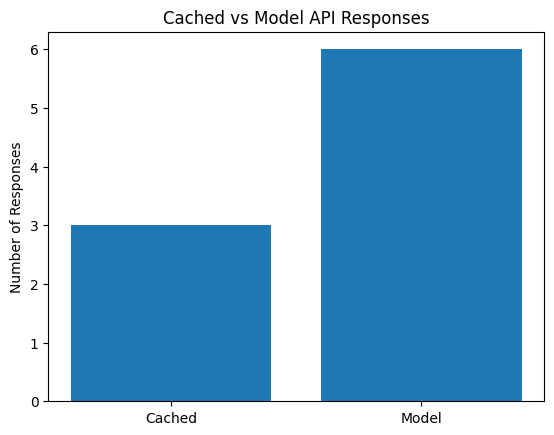

Cached Responses: 3
Model Responses: 6


In [14]:
import os
import time
import matplotlib.pyplot as plt


# List of example user messages
user_messages = [
    "Hello, what's the weather in San Francisco??",
    "what's the weather in San Francisco??"
    "Can you tell me about the latest news?",
    "What's the capital of France?",
    "How does photosynthesis work?",
    "capital of france?",
    "tell me a joke",
    "tell me a joke right now"
    "How do I bake a chocolate cake?",
    "What are the benefits of exercise?",
    "Tell me a joke!",
    # Add more questions here
]

similarity_threshold = 0.5  # Adjust as needed

### Testing / Measuring
cached_responses = 0
model_responses = 0

for user_message in user_messages:
    messages = [{"content": user_message, "role": "user"}]

    start = time.time()
    response = completion_with_cache(messages=messages, similarity_threshold=similarity_threshold)
    end = time.time()
    response_time = end - start

    if response_time < 1:  # Assuming cached responses come in less than 1s
        cached_responses += 1
    else:
        model_responses += 1
    print(f"got response for {user_message}")

# Plotting
response_types = ["Cached", "Model"]
response_counts = [cached_responses, model_responses]

fig, ax = plt.subplots()
ax.bar(response_types, response_counts)
ax.set_ylabel("Number of Responses")
ax.set_title("Cached vs Model API Responses")
plt.show()

print(f"Cached Responses: {cached_responses}")
print(f"Model Responses: {model_responses}")